# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": False, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 2 , # Number of pseudo-experiments to run per set
"num_of_sets" : 5, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from numpy.random import RandomState
import warnings
import os
import sys
warnings.filterwarnings("ignore")

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
submission_dir = os.path.join(root_dir, "sample_code_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")
    
test_settings = TEST_SETTINGS.copy()

if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)


Root directory is /clusterfs/ml4hep/jvdudley/projects/FairUniverse/examples/HEP-Challenge



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = True

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71566438 entries, 0 to 71566437
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 7.5 GB
None
[+] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [ ]:
train_visualize = Dataset_visualise(
    data_set=data.get_train_set(),
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [ ]:
# Show data summary
train_visualize.examine_dataset()

In [ ]:
# Show data summary
train_visualize.histogram_dataset()

In [ ]:
train_visualize.stacked_histogram("DER_deltar_had_lep")

In [ ]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [ ]:
syst_train_data = data.get_syst_train_set()

In [ ]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

In [ ]:
bootstraped_data = data.generate_psuedo_exp_data()

In [ ]:
# Show data summary
train_visualize.examine_dataset()

In [ ]:
print("sum of weights = ", (bootstraped_data["weights"]).sum())

***
# Program
***


In [13]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [14]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model
[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71566438 entries, 0 to 71566437
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 7.5 GB
None
[+] Train data loaded successfully
Full data:  (71566438, 28)
Full Labels:  (71566438,)
Full Weights:  (71566438,)
sum_signal_weights:  3639.452945491281
sum_bkg_weights:  3746751.113618623
 
 
Full size of the data is 71566438
Train size is 43408271
Test size is 35783219
Training Data:  (43408271, 28)
Training Labels:  (43408271,)
Training Weights:  (43408271,)
sum_signal_weights:  3639.4529454912804
sum_bkg_weights:  3746751.113618624

Valid Data:  (35783219, 28)
Valid Labels:  (35783219,)
Valid Weights:  (35783219,)
sum_signal_weights:  3639.452945491285
sum_bkg_weights:  3746751.113618623
 
 
Training Data:  (43408271, 28)


2024-07-25 09:25:55.789918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 09:25:55.789954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 09:25:55.790862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 09:25:55.796465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 09:26:02.468859:

8 Physical GPUs, 1 Logical GPUs
Model is TF NN


In [15]:

# fit submission
ingestion.fit_submission()

[*] Calling fit method of submitted model
42/42 [==============================] - 3s 44ms/step


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:

# load test set
data.load_test_set()

In [ ]:

# predict submission
ingestion.predict_submission(test_settings)

In [ ]:
ingestion.compute_result()

In [ ]:

# save result
ingestion.save_result(output_dir)

***
# Likelihood plots
***

In [15]:
from tqdm import tqdm

from systematics import postprocess, systematics
from pathlib import Path
from systematics import LHC_NUMBERS as LHC_NUMBERS_NEW

In [16]:
def NLL(mu, observed, expected_sig, expected_bkgd, scale=1, epsilon=1e-30):
    # need to double check the scaling
    expected = scale * (mu * expected_sig + expected_bkgd)
    return np.sum(expected - observed * np.log(expected + epsilon))

In [17]:
def NLLarray(mus, observed, expected_sig, expected_bkgd, epsilon=1e-30):
    expected = (mus[:, None] * expected_sig + expected_bkgd)
    return (expected - observed * np.log(expected + epsilon)).sum(axis=1)

In [18]:
def get_results(mus, nlls):
    mu_hat = mus[np.argmin(nlls)]
    one_sigma = mus[(nlls - np.min(nlls)) < 0.5]
    return mu_hat, (one_sigma[0], one_sigma[-1])

In [330]:
num_bins = 50
hist_bins = np.linspace(0, 1, num_bins+1)

In [255]:

mus = np.linspace(.25, 1.75, 10**5) # negtive mu breaks when using labels in place of scores

In [21]:
LHC_NUMBERS = {
    "ztautau": 3544019,
    "diboson": 40590,
    "ttbar": 158761,
    "htautau": 3639,
}

## Checking event counts

In [53]:
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71566438 entries, 0 to 71566437
Columns: 28 entries, PRI_lep_pt to DER_lep_eta_centrality
dtypes: float32(28)
memory usage: 7.5 GB
None
[+] Train data loaded successfully


In [54]:
all_weighted_data = data.get_train_set().copy()

In [55]:
for k, v in all_weighted_data.items():
    print(k, type(v))

data <class 'pandas.core.frame.DataFrame'>
labels <class 'numpy.ndarray'>
settings <class 'dict'>
weights <class 'numpy.ndarray'>
detailed_labels <class 'list'>


In [56]:
all_weighted_data['detailed_labels'] = np.array(all_weighted_data['detailed_labels'])

ztautau (25863940,) 0.1381873158898656 1.2212453270876722e-15
0.138187    25863940
Name: count, dtype: int64
diboson (1481170,) 0.009183793736224933 0.000796520686424391
0.009093    1207648
0.010798     187983
0.006916      85539
Name: count, dtype: int64
ttbar (1891699,) 0.08409366760453979 0.00039276755271295746
0.084186    1602629
0.083485     210857
0.084191      73195
0.080197       3702
0.074173       1311
0.137161          5
Name: count, dtype: int64
htautau (42329629,) 8.597885290918285e-05 5.3319281986074824e-06
0.000086    33185450
0.000086     3667119
0.000086     1620564
0.000086     1400210
0.000086     1154665
0.000087      743735
0.000086      394671
0.000000      161973
0.000069        1242
Name: count, dtype: int64


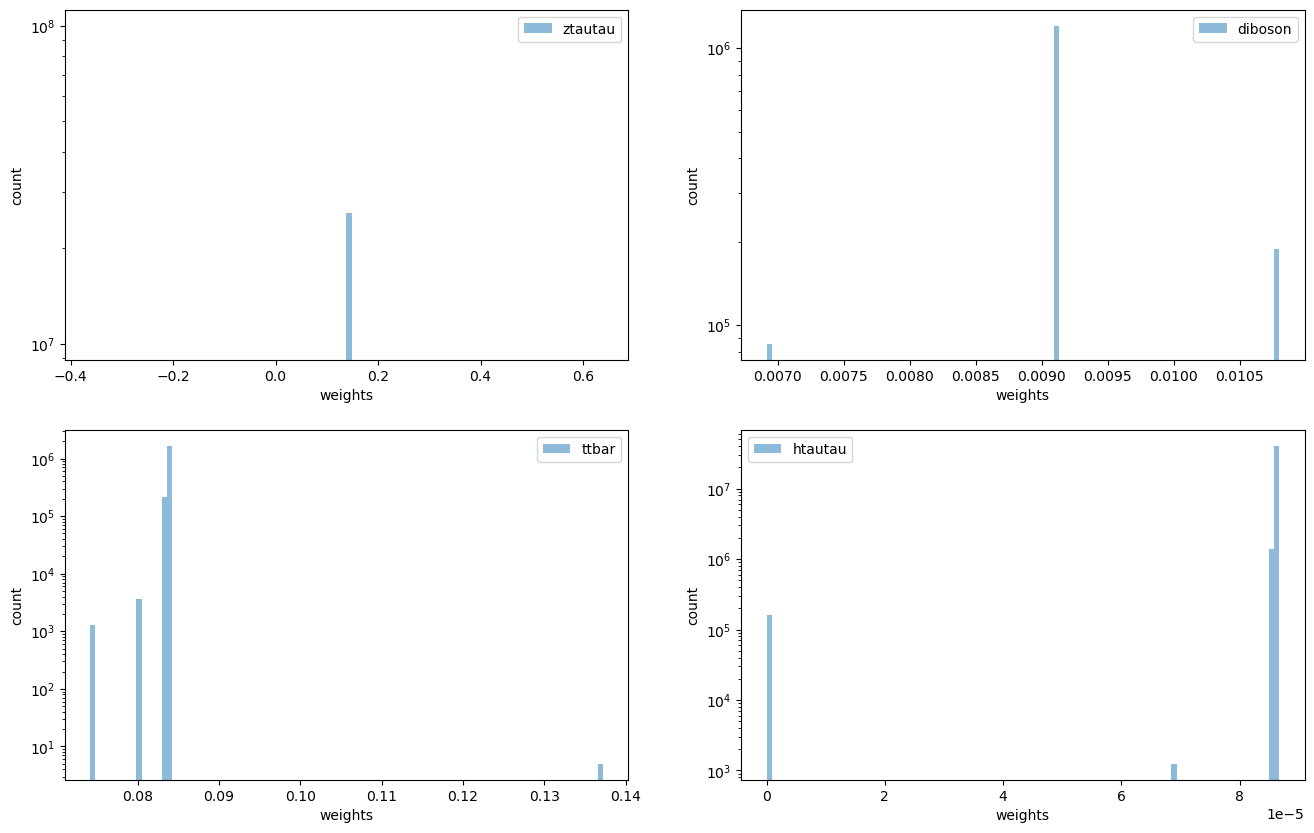

In [163]:
# {name: all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name] for name in LHC_NUMBERS}
# plt.figure(figsize=(16, 10))
plt.subplots(2, 2, figsize=(16, 10))
for j, name in enumerate(LHC_NUMBERS, start=1):
    plt.subplot(2, 2, j)
    tmp_weights = all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name]
    print(name, tmp_weights.shape, tmp_weights.mean(), tmp_weights.std())
    print(pd.Series(tmp_weights).value_counts())
    plt.hist(tmp_weights, bins=100, density=False, alpha=0.5, label=name)
    # plt.title(name)
# plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.legend()
# plt.title('weighted data')


In [167]:
(all_weighted_data['weights'][all_weighted_data['detailed_labels'] == 'htautau'] == 0).sum(), (all_weighted_data['detailed_labels'] == 'htautau').sum()

(161973, 42329629)

In [122]:
counts_df = pd.DataFrame.from_dict(
    {
        name: {
            'LHC_NUMBERS (old)': LHC_NUMBERS[name],
            'sum of weights': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
            'num weighted events': (all_weighted_data['detailed_labels'] == name).sum(),
            'average weight': all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].mean(),
        }
        for name in LHC_NUMBERS
    },
    orient='index',
)

In [123]:
counts_df.T.style.format(precision=6)

,ztautau,diboson,ttbar,htautau
LHC_NUMBERS (old),3544019.000000,40590.000000,158761.000000,3639.000000
sum of weights,3574068.446937,13602.759768,159079.906914,3639.452945
num weighted events,25863940.000000,1481170.000000,1891699.000000,42329629.000000
average weight,0.138187,0.009184,0.084094,0.000086


## Comparison

Use scores and weights from Sascha

In [114]:
bresult = [] # list of dictionaries of results of varying num_bins

In [23]:
sresults = {}

In [61]:
# sascha_dir = Path('/global/ml4hep/spss/jvdudley/physicsData/FairUniverse/comparison_Sascha/Fair_Universe_Comparison_Data/')
sascha_dir = Path('/global/ml4hep/spss/sdiefenbacher/Fair_Universe/comparison/comparison_templates_data_07_23_seed45/')
# sprefix = 'Run_9'

In [65]:
for file in sascha_dir.glob('eval*.npy'):
    # if file.stem.startswith('Run'): continue
    print(file.stem)

eval_weights
eval_values


In [81]:
def sread(pattern, dir=sascha_dir):
    return {file.stem: np.load(file) for file in dir.glob(pattern)}

In [82]:
sread('eval*.npy')

{'eval_weights': array([1., 1., 1., ..., 1., 1., 1.]),
 'eval_values': array([0.94426656, 0.5029457 , 0.14389   , ..., 0.23020749, 0.39479893,
        0.12313514], dtype=float32)}

In [83]:
sread('Run_0*.npy')

{'Run_0eval_values': array([0.17779735, 0.5458482 , 0.1314647 , ..., 0.15759012, 0.46404898,
        0.23085658], dtype=float32),
 'Run_0eval_weights': array([1., 1., 1., ..., 1., 1., 1.])}

In [ ]:
for pattern in ('eval*.npy', 'Run_0*.npy', '*bkg*.npy'):
    plt.hist()

In [84]:
stdata = {}
sedata = {}

sdata = {}

In [85]:
# for pattern in ('*sig*.npy', '*bkg*.npy', '*Run_*.npy'):
for name, data in sread('*.npy').items():
    # print(name, data.shape)
    if name.endswith('_weights'):
        tmpsuffix = 'weights'
    elif name.endswith('_values'):
        tmpsuffix = 'values'
    else:
        raise ValueError(f'{name} does not end with "_weights" or "_values"')
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix.startswith('Run_'):
        tmpprefix = int(tmpprefix.removeprefix('Run_').removesuffix('eval'))
    if tmpprefix not in sdata:
        sdata[tmpprefix] = {}
    sdata[tmpprefix][tmpsuffix] = data

In [75]:
for name, data in sread('*Run_*.npy').items():
    tmpprefix = name.removesuffix('_weights').removesuffix('_values')
    if tmpprefix not in sedata:
        sedata[tmpprefix] = {}
    sedata[tmpprefix][name.removeprefix(tmpprefix + '_')] = data

In [72]:
sedata['Run_0eval'].keys()

dict_keys(['values', 'weights'])

In [ ]:
sascha_copy = {file.stem: np.load(file) for file in sascha_dir.glob('*bkg*.npy')}
sascha_data = {}


In [ ]:
for name in sascha_copy:
    tmp_prefix = name.removesuffix('_values').removesuffix('_weights')
    if tmp_prefix not in sascha_data:
        sascha_data[tmp_prefix] = {}
    sascha_data[tmp_prefix][name.removeprefix(tmp_prefix + '_')] = sascha_copy[name]
del sascha_copy

In [158]:
sascha_hist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sascha_data.items()}

NameError: name 'sascha_data' is not defined

In [331]:
shist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in tqdm(sdata.items())}

100%|██████████| 503/503 [00:59<00:00,  8.41it/s]


In [226]:
svar = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights']**2)[0] for name, data in tqdm(sdata.items())}

100%|██████████| 503/503 [00:59<00:00,  8.44it/s]


In [52]:
sthist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in stdata.items()}
sehist = {name: np.histogram(data['values'], bins=hist_bins, weights=data['weights'])[0] for name, data in sedata.items()}

In [227]:
(np.sqrt(shist['template_sig'] + shist['template_bkg']) / np.sqrt((svar['template_sig'] + svar['template_bkg']))).min()

1.9171400844815423

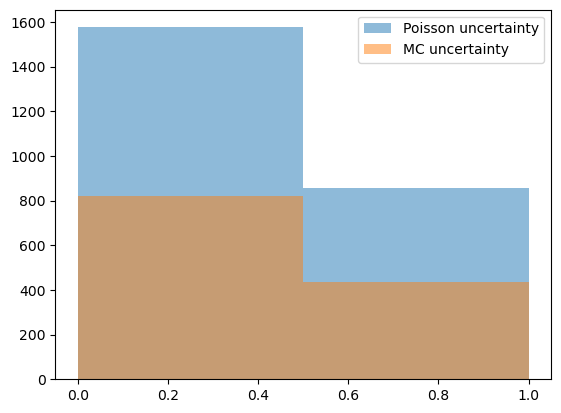

In [228]:
plt.stairs(
    np.sqrt(shist['template_sig'] + shist['template_bkg']),
    hist_bins,
    label='Poisson uncertainty',
    # color='blue',
    alpha=0.5,
    fill=True,
)
plt.stairs(
    np.sqrt(svar['template_sig'] + svar['template_bkg']),
    hist_bins,
    label='MC uncertainty',
    # color='red',
    alpha=0.5,
    fill=True,
)
plt.legend()

Text(0.5, 1.0, 'pseudoexperiments - bkg template')

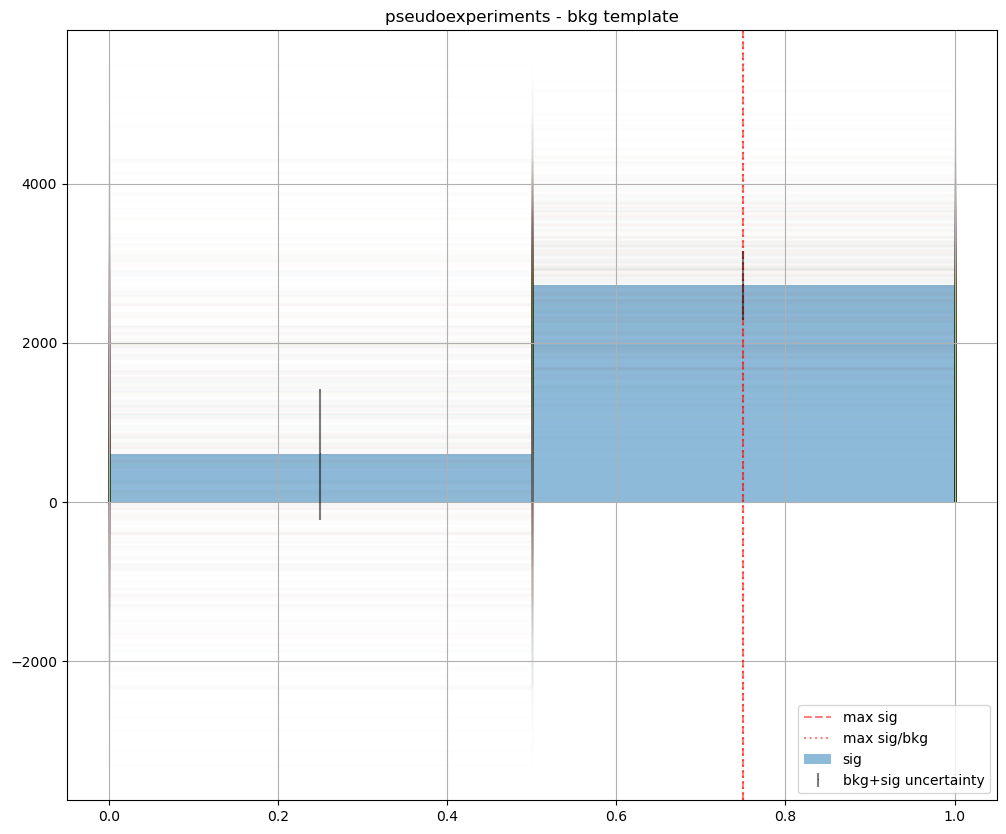

In [229]:
plt.figure(figsize=(12, 10))
plt.axvline(
    hist_bins[shist['template_sig'].argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle='--',
    label='max sig',
    alpha=0.5,
)
plt.axvline(
    hist_bins[(shist['template_sig'] / shist['template_bkg']).argmax()] + (hist_bins[1] - hist_bins[0]) / 2,
    color='red',
    linestyle=':',
    label='max sig/bkg',
    alpha=0.5,
)
# plt.hist(
#     [hist_bins[:-1],] * 2,
#     hist_bins,
#     weights=[hist for name, hist in shist.items() if isinstance(name, str)],
#     alpha=0.5,
#     label=[name for name in shist if isinstance(name, str)],
#     histtype='barstacked',
# )
# tmp_vals = 0
# tmp_baseline = 0
# for sb in ('template_bkg', 'template_sig'):
#     tmp_vals += shist[sb]
#     plt.stairs(
#         tmp_vals,
#         hist_bins,
#         alpha=0.5,
#         label=sb,
#         baseline=tmp_baseline,
#         fill=True,
#     )
#     tmp_baseline += shist[sb]
plt.stairs(
    shist['template_sig'],
    hist_bins,
    alpha=0.5,
    label='sig',
    fill=True,
)
plt.errorbar(
    (hist_bins[:-1] + hist_bins[1:]) / 2,
    shist['template_sig'], # + shist['template_bkg']
    1 * np.sqrt(svar['template_sig'] + svar['template_bkg']),
    fmt=',',
    color='black',
    # drawstyle='steps-mid',
    label='bkg+sig uncertainty',
    alpha=0.5,
)
for name, hist in shist.items():
    if isinstance(name, str):
        continue
    plt.stairs( # hist(
        hist - shist['template_bkg'], # hist_bins[:-1],
        hist_bins,
        # weights=hist - shist['template_bkg'],
        alpha=0.01,
        # label=name,
        # histtype='step',
    )
# plt.yscale('log')
# plt.xlim(.9, 1)
# plt.ylim(4e1, 1.3e3)
plt.grid()
plt.legend()
plt.title('pseudoexperiments - bkg template')

In [184]:
sascha_data.keys()

dict_keys(['Run_9template_bkg', 'Run_9eval', 'Run_9template_sig'])

In [115]:
# sascha_nlls = [
#     NLL(
#         mu,
#         sascha_hist[sprefix + 'eval'],
#         sascha_hist[sprefix + 'template_sig'],
#         sascha_hist[sprefix + 'template_bkg'],
#     ) for mu in mus
# ]
sascha_nlls = NLLarray(
    mus,
    shist[0],
    shist['template_sig'],
    shist['template_bkg'],
)

In [116]:
sascha_one_sigma = np.array(mus)[(sascha_nlls - min(sascha_nlls)) < 0.5]

In [187]:
sresults[sprefix] = (sascha_one_sigma[0], sascha_one_sigma[-1])

Text(0.5, 1.0, 'Comparison:Run_9')

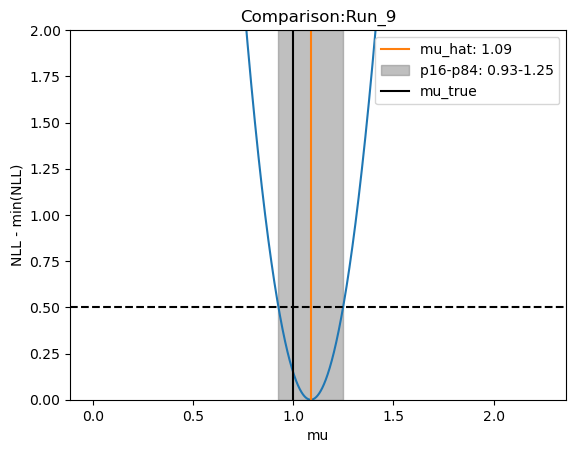

In [117]:
plt.plot(mus, sascha_nlls - min(sascha_nlls))
plt.axhline(.5, color='black', linestyle='--')
plt.axvline(mus[np.argmin(sascha_nlls)], color='C1', label=f'mu_hat: {mus[np.argmin(sascha_nlls)]:.2f}')
# plt.axvline(sascha_one_sigma[0], color='r', label=f'p16: {sascha_one_sigma[0]:.2f}')
# plt.axvline(sascha_one_sigma[-1], color='r', label=f'p84: {sascha_one_sigma[-1]:.2f}')
plt.axvspan(sascha_one_sigma[0], sascha_one_sigma[-1], color='grey', alpha=0.5, label=f'p16-p84: {sascha_one_sigma[0]:.2f}-{sascha_one_sigma[-1]:.2f}')
# plt.axvline(1.45, color='C2', label='mu_hat (Sascha)')
# plt.axvline(1.3952, color='C3', label='mu_hat (Yulei)')
plt.axvline(1, color='black', label='mu_true')
# plt.plot(mus, 5.1 * (mus - mus[np.argmin(sascha_nlls)])**2, label='(mu - mu_hat)^2')
plt.ylim(0, 2)
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
plt.legend()
plt.title('Comparison:' + sprefix)

In [332]:
sresults = {}

In [333]:
for name, hist in tqdm(shist.items(), 'computing results from histograms'):
    # print(name)
    if isinstance(name, str):
        continue
    snlls = NLLarray(mus, hist, shist['template_sig'], shist['template_bkg'])
    #     NLL(
    #         mu,
    #         hist,
    #         shist['template_sig'],
    #         shist['template_bkg'],
    #     ) for mu in mus
    # ]
    sresults[name] = get_results(mus, snlls)

computing results from histograms: 100%|██████████| 503/503 [00:44<00:00, 11.37it/s]


In [334]:
intervals = np.array([t for _, t in sresults.values()])

In [335]:
assert mus[1] < intervals.min(), f'mus starts too high'
print(f'{mus[1]:.3f} < {intervals.min():.3f}')
assert mus[-2] > intervals.max(), f'mus ends too low'
print(f'{mus[-2]:.3f} > {intervals.max():.3f}')


0.250 < 0.389
1.750 > 1.666


In [336]:
# bresult[num_bins] = (intervals.mean(), ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean())
bresult.append({
    'mean': intervals.mean(),
    'stderr': intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    'coverage': ((intervals[:, 0] < 1) & (intervals[:, 1] > 1)).mean(),
    'num_pseudo_experiments': intervals.shape[0],
    'num_bins': num_bins,
})

# print(f'mean: {bresult[num_bins][0]:.3f}, coverage: {bresult[num_bins][1]:.3f}')
print(bresult[-1])

{'mean': 1.030270782707827, 'stderr': 0.007420840087930377, 'coverage': 0.664, 'num_pseudo_experiments': 500, 'num_bins': 50}


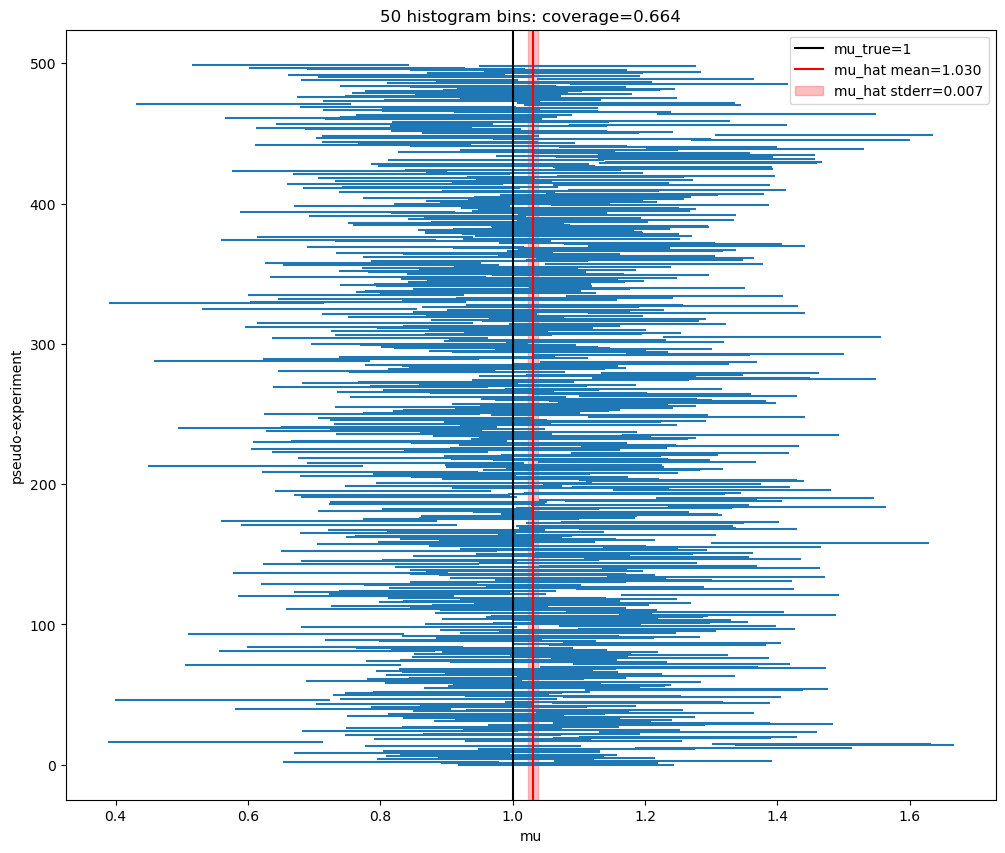

In [337]:
plt.figure(figsize=(12, 10))
plt.hlines(
    [name for name in sresults],
    [p16 for _, (p16, _) in sresults.values()],
    [p84 for _, (_, p84) in sresults.values()],
)
# plot mu_true: currently 1
plt.axvline(1, color='black', label=f'mu_true=1')
# plot mu_hat mean
plt.axvline(bresult[-1]['mean'], color='r', label=f'mu_hat mean={bresult[-1]["mean"]:.3f}')
# plot mu_hat stderr
plt.axvspan(
    bresult[-1]['mean'] - bresult[-1]['stderr'],
    bresult[-1]['mean'] + bresult[-1]['stderr'],
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={bresult[-1]["stderr"]:.3f}',
)
plt.xlabel('mu')
plt.ylabel('pseudo-experiment')
plt.title(f'{num_bins} histogram bins: coverage={bresult[-1]["coverage"]:.3f}')
plt.legend()

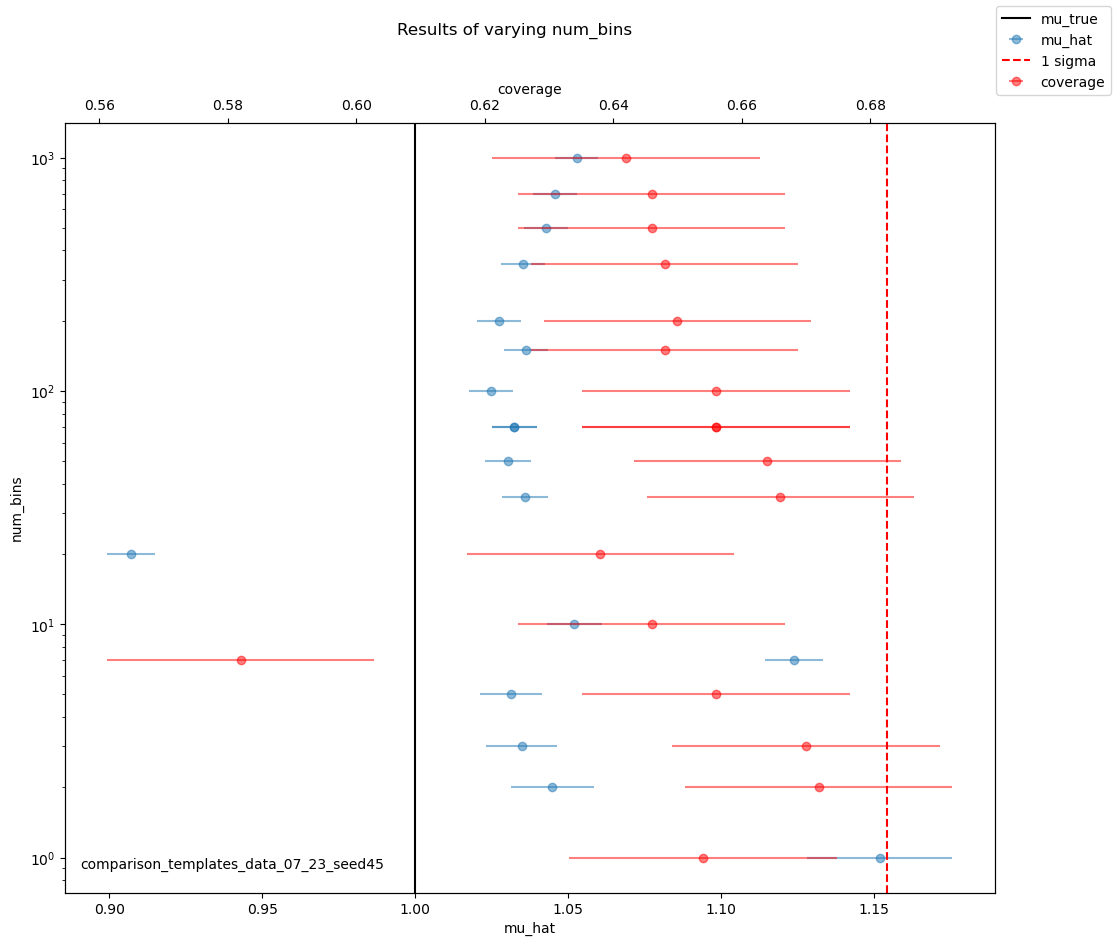

In [329]:
# bresult plots of mean±stderr and coverage vs num_bins
fig = plt.figure(figsize=(12, 10))
plt.errorbar(
    [b['mean'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[b['stderr'] for b in bresult],
    fmt='o',
    label='mu_hat',
    alpha=0.5,
)
plt.axvline(1, color='black', label='mu_true')
plt.yscale('log')
plt.ylabel('num_bins')
plt.xlabel('mu_hat')
plt.twiny()
plt.errorbar(
    [b['coverage'] for b in bresult],
    [b['num_bins'] for b in bresult],
    xerr=[np.sqrt(.682689 * (1 - .682689) / b['num_pseudo_experiments']) for b in bresult],
    fmt='ro',
    label='coverage',
    alpha=0.5,
)
plt.axvline(.682689, color='r', linestyle='--', label='1 sigma')
# plt.axhspan(
#     .682689 - np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     .682689 + np.sqrt(.682689 * (1 - .682689) / bresult[-1]['num_pseudo_experiments']),
#     color='grey',
#     alpha=0.25,
# )
plt.xlabel('coverage')
plt.suptitle('Results of varying num_bins')
plt.text(.557, .9, sascha_dir.stem)
fig.legend()

In [46]:
cresults = {
    'Jordan': {
        'Run_0': (0.8823613236132362, 1.1882118821188212),
        'Run_1': (0.8945064450644507, 1.1997444974449745),
        'Run_2': (0.8033480334803348, 1.115131151311513),
        'Run_3': (0.9987899878998789, 1.3043430434304342),
        'Run_4': (0.9687946879468795, 1.2695876958769587),
        'Run_5': (0.9235392353923539, 1.232959829598296),
        'Run_6': (1.180021800218002, 1.4898273982739827),
        'Run_7': (1.091540915409154, 1.4003315033150332),
        'Run_8': (1.0722382223822238, 1.378928789287893),
        'Run_9': (1.0410879108791087, 1.3475684756847568),
    },
    'Sascha': {
        'Run_0': (0.901194159732266, 1.2062761636214896),
        'Run_1': (0.8894361103293542, 1.1950205736920794),
        'Run_2': (0.8156946813859971, 1.1266712540266663),
        'Run_3': (0.9982769846663299, 1.3037225824265635),
        'Run_4': (0.9674725796855451, 1.2681422564378708),
        'Run_5': (0.9341876695842286, 1.2431236399605807),
        'Run_6': (1.210834505642529, 1.5191684157141783),
        'Run_7': (1.1024395216920113, 1.4106339865777082),
        'Run_8': (1.0826025589257644, 1.388693180595792),
        'Run_9': (1.0624547927260337, 1.3678220195383683),
    },
    'Yulei': [
        (0.8641240477713032, 1.1685347528269672),
        (0.8534984694263906, 1.1566380803920224),
        (0.8163559424937542, 1.1282676529144529),
        (1.0138248845573359, 1.3189941669186172),
        (0.9976235681984136, 1.2983202394845823),
        (0.8384660075098151, 1.145517502230531),
        (1.0601399318867162, 1.3669774991943608),
        (1.0648479946635852, 1.3725732313530639),
        (1.1072575393906805, 1.4142756561289402),
        (0.9287805137600891, 1.2318307738852956),
    ],
}

In [47]:
cresults['Yulei'] = {f'Run_{j}': vals for j, vals in enumerate(cresults['Yulei'])}

Text(0.5, 1.0, 'Coverage comparison')

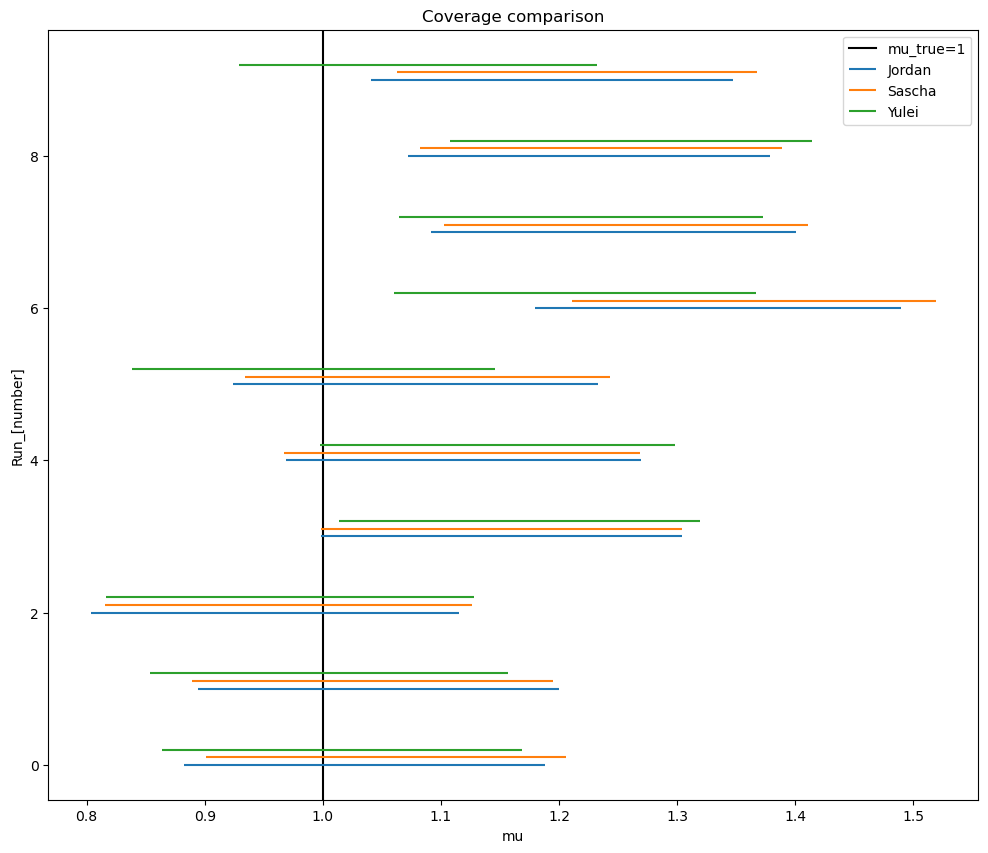

In [48]:
plt.figure(figsize=(12, 10))
plt.axvline(1, color='black', label='mu_true=1')
for j, (name, results) in enumerate(cresults.items()):
    plt.hlines(
        [int(run.removeprefix('Run_')) + j/10 for run in results],
        [p16 for p16, _ in results.values()],
        [p84 for _, p84 in results.values()],
        color=f'C{j}',
        label=name,
    )
plt.xlabel('mu')
plt.ylabel('Run_[number]')
plt.legend()
plt.title('Coverage comparison')

## Predict mu for test data

This does not include postselection cuts

In [22]:
# read data: train, valid, test
train_set = ingestion.model.training_set.copy()
valid_set = ingestion.model.stat_analysis.holdout_set.copy()
ingestion.data.load_test_set()
test_set = ingestion.data.get_test_set().copy()


[*] Loading Test data
[+] Test data loaded successfully


In [40]:
pseudo_exp_data = ingestion.data.generate_psuedo_exp_data(seed=3141592653)

In [41]:
assert (pseudo_exp_data['weights'] == 1).all(), 'pseudo experiment data weights are not all one'

In [124]:
counts_df['num unweighted events'] = {name: df.shape[0] for name, df in data.get_test_set().items()}

In [165]:
counts_df.T.style.format(precision=3, thousands=',').format(precision=6, subset=('average weight',))

,ztautau,diboson,ttbar,htautau
LHC_NUMBERS (old),"3,544,019.000","40,590.000","158,761.000","3,639.000"
sum of weights,"3,574,068.447","13,602.760","159,079.907","3,639.453"
num weighted events,"25,863,940.000","1,481,170.000","1,891,699.000","42,329,629.000"
average weight,0.138187,0.009184,0.084094,0.000086
num unweighted events,"7,211,236.000","81,180.000","317,522.000","7,278.000"


In [24]:
sums_by_type = {
    name: (
        # all_weighted_data['weights'][all_weighted_data['detailed_labels'] == name].sum(),
        train_set['weights'][train_set['detailed_labels'] == name].sum(),
        valid_set['weights'][valid_set['detailed_labels'] == name].sum(),
    )
    for name in LHC_NUMBERS
}

In [36]:
sums_by_type['bkgd'] = (
    all_weighted_data['weights'][all_weighted_data['labels'] == 0].sum(),
    train_set['weights'][train_set['labels'] == 0].sum(),
    valid_set['weights'][valid_set['labels'] == 0].sum(),
)

In [37]:
for name, sums in sums_by_type.items():
    print(f'{name}:\nall: {sums[0]:.3f}, train: {sums[1]:.3f}, valid: {sums[2]:.3f}')
    print(f'min: {min(sums[1:]):.3f}\nmax: {max(sums[1:]):.3f}')
    # print(min(sums[1:]) < sums[0] < max(sums[1:]))
    if sums[0] < min(sums[1:]):
        print(f'Warning: {name} sum of weights in all data less than in train and valid data')
    elif sums[0] > max(sums[1:]):
        print(f'Warning: {name} sum of weights in all data greater than in train and valid data')
    else:
        print(f'{name} sum of weights in all data is between train and valid data')

ztautau:
all: 3574068.447, train: 3574029.321, valid: 3574144.844
min: 3574029.321
max: 3574144.844
ztautau sum of weights in all data is between train and valid data
diboson:
all: 13602.760, train: 13588.522, valid: 13624.829
min: 13588.522
max: 13624.829
diboson sum of weights in all data is between train and valid data
ttbar:
all: 159079.907, train: 159133.270, valid: 158981.440
min: 158981.440
max: 159133.270
ttbar sum of weights in all data is between train and valid data
htautau:
all: 3639.453, train: 3639.453, valid: 3639.453
min: 3639.453
max: 3639.453
htautau sum of weights in all data is between train and valid data
bkgd:
all: 3746751.114, train: 3746751.114, valid: 3746751.114
min: 3746751.114
max: 3746751.114
bkgd sum of weights in all data is between train and valid data


In [24]:
# replace LHC_NUMBERS[name] with counts_df['sum of weights'][name].round().astype(int)

# for key in test_set:
#     print(key, test_set[key].shape)
#     assert test_set[key].shape[0] >= LHC_NUMBERS[key], f'{key} test set is too small'
#     test_set[key] = test_set[key].copy()[:LHC_NUMBERS[key]]
print(data.get_test_set()['htautau'].shape)
test_set_samples = {}
for name, df in test_set.items():
    print(f'{name}: unweighted events={df.shape[0]}, old expectation={LHC_NUMBERS[name]}, ratio={df.shape[0] / LHC_NUMBERS[name]}, new expectation={LHC_NUMBERS_NEW[name]}')
    assert df.shape[0] > LHC_NUMBERS_NEW[name], f'{name} test set is too small'
    test_set_samples[name] = df[:int(LHC_NUMBERS_NEW[name] + .5)]
test_set = test_set_samples
print(data.get_test_set()['htautau'].shape)

(7278, 28)
ztautau: unweighted events=7211236, old expectation=3544019, ratio=2.0347622289835354, new expectation=3574068.447
diboson: unweighted events=81180, old expectation=40590, ratio=2.0, new expectation=13602.76
ttbar: unweighted events=317522, old expectation=158761, ratio=2.0, new expectation=159079.907
htautau: unweighted events=7278, old expectation=3639, ratio=2.0, new expectation=3639.453
(7278, 28)


In [25]:
valid_syst = systematics(valid_set.copy())

In [26]:
valid_syst['weights'].sum(), pseudo_exp_data['weights'].sum(), sum((df.shape[0] for df in test_set.values()))

(3377038.0703578987, 3380580.0, 3750390)

In [27]:
valid_set = valid_syst

In [28]:
for name in test_set:
    print(name, '\n', test_set[name].shape)
    test_set[name] = postprocess(test_set[name])
    print(test_set[name].shape)

ztautau 
 (3574068, 28)
(3213011, 28)
diboson 
 (13603, 28)
(12302, 28)
ttbar 
 (159080, 28)
(148532, 28)
htautau 
 (3639, 28)
(3448, 28)


In [42]:
n_expected = valid_set['weights'].sum()
n_observed = np.sum([data.shape[0] for data in test_set.values()])
n_pseudo = pseudo_exp_data['data'].shape[0]

n_expected, n_observed, n_pseudo

(3377038.0703578987, 3377293, 3378367)

In [30]:
train_set['scores'] = ingestion.model.model.predict(train_set['data'])
valid_set['scores'] = ingestion.model.model.predict(valid_set['data'])

32/32 [==============================] - 2s 45ms/step


In [43]:

pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)

In [ ]:
test_scores = {
    name: ingestion.model.model.predict(test_set[name])
    for name in test_set.keys()
}

In [44]:
histograms = { # train/valid, sig/bkgd
    tv + sb: np.histogram(
        dataset['scores'][dataset['labels'] == (1-j)], # testing using the label as the score
        bins=hist_bins,
        weights=dataset['weights'][dataset['labels'] == (1-j)],
        # range=(0, 1),
    )
    for tv, dataset in {'train': train_set, 'valid': valid_set}.items()
    for j, sb in enumerate(['_sig', '_bkgd'])
}
pseudo_exp_hist = np.histogram(
    pseudo_exp_data['scores'], # testing using the label as the score
    bins=hist_bins,
    # weights=pseudo_exp_data['weights'], # weights are all 1
    # range=(0, 1),
)
test_hist = {
    name: np.histogram(
        scores,
        bins=hist_bins,
        # range=(0, 1),
    )
    for name, scores in test_scores.items()
}

In [45]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0]).min()

149.5698589364754

In [46]:
histograms_var ={
    'valid_sig': np.histogram(
        valid_set['scores'][valid_set['labels'] == 1],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 1]**2,
    )[0],
    'valid_bkgd':np.histogram(
        valid_set['scores'][valid_set['labels'] == 0],
        bins=hist_bins,
        weights=valid_set['weights'][valid_set['labels'] == 0]**2,
    )[0],
}



In [47]:
(histograms['valid_bkgd'][0] + histograms['valid_sig'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'] + histograms_var['valid_sig'])).min()

143.20564569654076

In [48]:
(histograms['valid_bkgd'][0] - 1 * np.sqrt(histograms_var['valid_bkgd'])).min()

143.1505626775907

In [49]:
pseudo_exp_hist[0].min(), np.sum([hist for hist, _ in test_hist.values()], axis=0).min()

(139, 0)

In [50]:
(pseudo_exp_hist[0] == 0).sum(), pseudo_exp_hist[0].argmin(), pseudo_exp_hist[0][:5], pseudo_exp_hist[0][-5:]

(0,
 0,
 array([139, 421, 590, 670, 702]),
 array([  359,   424,   591,   820, 10770]))

Text(0.5, 1.0, 'scores')

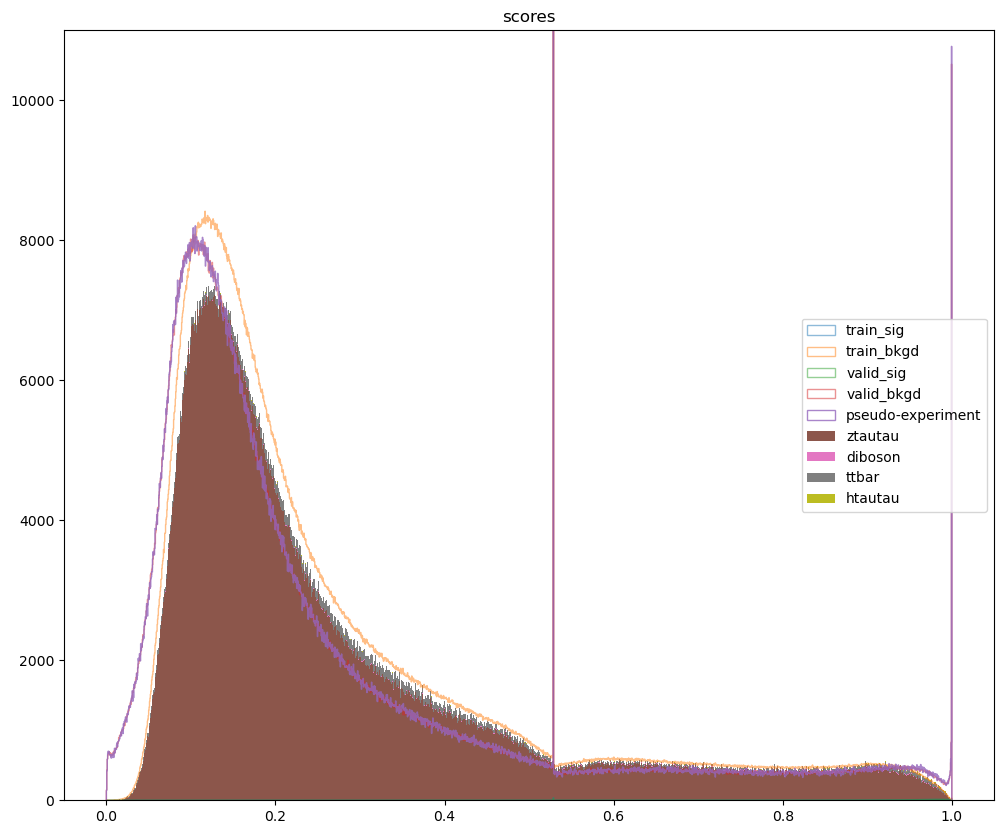

In [51]:
plot_density = False
plot_scaled = False

plt.figure(figsize=(12, 10))
for name, (hist, bins) in histograms.items():
    plt.hist(
        bins[:-1],
        bins,
        weights=hist * ((n_observed / n_expected) if plot_scaled else 1),
        label=name + (' (scaled)' if plot_scaled else ''),
        density=plot_density,
        histtype='step', # if 'train' in name else 'bar',
        alpha=.5 if 'valid' in name else 0.5,
    )
plt.hist(
    hist_bins[:-1],
    hist_bins,
    weights=pseudo_exp_hist[0],
    label='pseudo-experiment',
    density=plot_density,
    histtype='step',
    alpha=.8,

)
# for name, (hist, bins) in test_hist.items():
#     plt.hist(
#         bins[:-1],
#         bins,
#         weights=hist,
#         label=(name + ' (test set)'),
#         density=plot_density,
#         histtype='bar',
#         stacked=True,
#         alpha=.5,
#     )
# tmp_hists = []
# tmp_weights = []
plt.hist(
    # [bins[:-1] for (hist, bins) in test_hist.values()],
    [hist_bins[:-1]] * len(test_hist),
    # test_hist['htautau'][1], # all bins are the same; pick one
    hist_bins,
    weights=[hist for (hist, bins) in test_hist.values()],
    label=[name for name in test_hist],
    density=plot_density,
    histtype='barstacked',
)
plt.ylim(0, 11e3)
plt.legend()
plt.title('scores')

In [40]:

nlls = [
    NLL(
        mu,
        histograms['train_sig'][0] + histograms['train_bkgd'][0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
    ) for mu in mus
]

'mu_hat = 2.25'

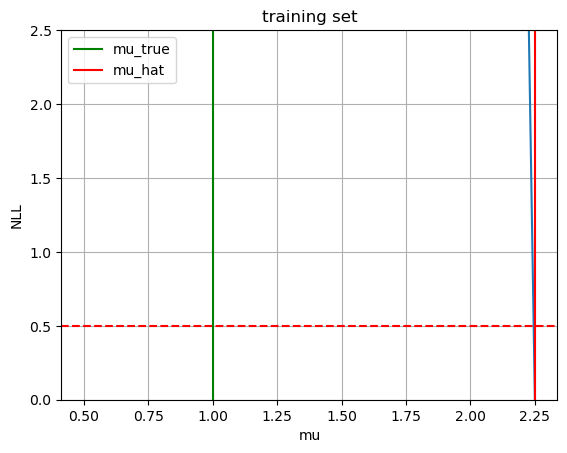

In [41]:
plt.plot(mus, nlls - min(nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='g', label='mu_true')
plt.axvline(mus[np.argmin(nlls)], color='r', label='mu_hat')
plt.xlabel('mu')
plt.ylabel('NLL')
plt.ylim(0, 2.5)
plt.grid()
plt.legend()
plt.title('training set')

f'mu_hat = {mus[np.argmin(nlls)]}'

In [42]:
test_nlls = [
    NLL(
        mu,
        # test_hist['htautau'][0] + test_hist['ztautau'][0],
        np.sum([hist for (hist, bins) in test_hist.values()], axis=0),
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

Text(0.5, 1.0, 'test set')

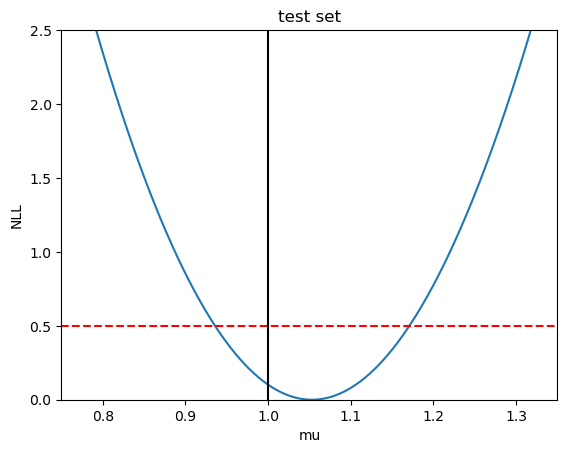

In [43]:
plt.plot(mus, test_nlls - min(test_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL')
plt.xlim(.75, 1.35)
plt.ylim(0, 2.5)
plt.title('test set')

In [44]:
pseudo_nlls = [
    NLL(
        mu,
        pseudo_exp_hist[0],
        histograms['valid_sig'][0],
        histograms['valid_bkgd'][0],
        # scale=(n_observed / n_expected),
    ) for mu in mus
]

Text(0.5, 1.0, 'pseudo experiment')

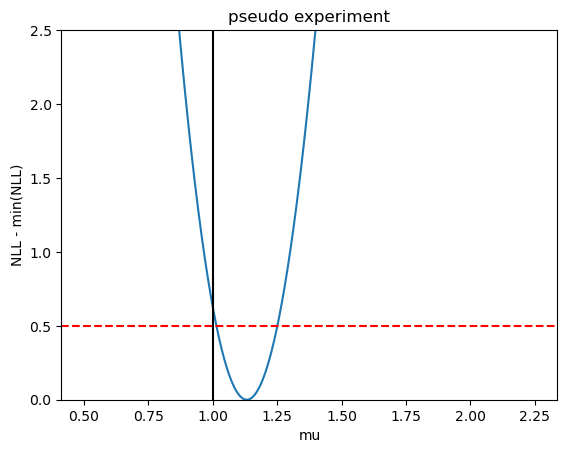

In [45]:
plt.plot(mus, pseudo_nlls - min(pseudo_nlls))
plt.axhline(.5, color='r', linestyle='--')
plt.axvline(1, color='black', label='mu_true')
plt.xlabel('mu')
plt.ylabel('NLL - min(NLL)')
plt.ylim(0, 2.5)
plt.title('pseudo experiment')

In [46]:
for name, v in pseudo_exp_data.items():
    print(name, v.shape[0], name in pseudo_exp_data['data'].columns)

weights 3380580 False
data 3380580 False
scores 3380580 False


In [110]:
pseudo_exp_counts, pseudo_exp_data['detailed_labels'].value_counts()

({'ztautau': 3213341, 'ttbar': 148298, 'diboson': 12298, 'htautau': 3417},
 detailed_labels
 ztautau    3213341
 ttbar       148298
 diboson      12298
 htautau       3417
 Name: count, dtype: int64)

In [59]:
seed_init = 3141592653
num_pseudo_experiments = 100
pseudo_results = []
mu_true = 1.75
pseudo_exp_frac = 1

# for seed in range(seed_init, seed_init + num_pseudo_experiments):
for j in tqdm(range(num_pseudo_experiments), f'Running {num_pseudo_experiments} pseudo-experiments'):
    # print(f'{j / num_pseudo_experiments:.2%} complete', end='\r', flush=True)
    seed = seed_init + j
    pseudo_exp_data, pseudo_exp_counts = ingestion.data.generate_psuedo_exp_data(mu_true, seed=seed, return_counts=True, lhc_frac=pseudo_exp_frac)
    # pseudo_exp_data = {name: v[:int(v.shape[0] / 10 + .5)] for name, v in pseudo_exp_data.items()} # only keep the first 10% of the data
    # pseudo_exp_counts = pseudo_exp_data['detailed_labels'].value_counts().to_dict()
    pseudo_exp_data['scores'] = ingestion.model.model.predict(pseudo_exp_data['data'], verbose=0)
    pseudo_exp_hist = np.histogram(
        pseudo_exp_data['scores'], # testing using the labels in place of the scores
        bins=hist_bins,
    )
    # pseudo_nlls = NLLarray(mus, pseudo_exp_hist[0], histograms['valid_sig'][0], histograms['valid_bkgd'][0])
    pseudo_nlls = [
        NLL(
            mu,
            pseudo_exp_hist[0],
            histograms['valid_sig'][0] * pseudo_exp_frac,
            histograms['valid_bkgd'][0] * pseudo_exp_frac,
        ) for mu in mus
    ]
    pseudo_results.append((seed, get_results(mus, pseudo_nlls), pseudo_exp_counts))

Running 100 pseudo-experiments: 100%|██████████| 100/100 [14:47<00:00,  8.87s/it]


In [60]:
intervals = np.array([result[1][1] for result in pseudo_results])

In [61]:
def sigma_fractions(intervals, mu_true=1, max_sigma=5):
    def n_sigma(n, means, intervals):
        return n * (intervals - means[:, None]) + means[:, None]
    means = intervals.mean(1)
    num_samples = intervals.shape[0]
    frac_within = [
        ((n_sigma(j, means, intervals)[:, 0] < mu_true) & (mu_true < n_sigma(j, means, intervals)[:, 1])).sum() / num_samples
        for j in range(1, max_sigma + 1)
    ]
    return frac_within

In [62]:
for j, frac in enumerate(sigma_fractions(intervals, mu_true)):
    print(f'fraction within {j+1} sigma: {frac:.2f}')

fraction within 1 sigma: 0.53
fraction within 2 sigma: 0.91
fraction within 3 sigma: 0.98
fraction within 4 sigma: 1.00
fraction within 5 sigma: 1.00


In [63]:
# for *_, counts in pseudo_results:
#     print(counts['htautau'] / mu_true)

valid_set['weights'][valid_set['labels'] == 1].sum(), test_set['htautau'].shape[0], np.mean([counts['htautau'] for *_, counts in pseudo_results])

(3462.270618083011, 3448, 6051.44)

In [64]:
tmp_stats = {}

In [65]:
tmp_stats['ddof'] = 1

tmp_stats['mu_hat_mean'] = intervals.mean()
tmp_stats['mu_hat_std'] = intervals.mean(1).std(ddof=tmp_stats['ddof'])
tmp_stats['mu_hat_stderr'] = tmp_stats['mu_hat_std'] / np.sqrt(intervals.shape[0])
tmp_stats['width_mean'] = (intervals[:, 1] - intervals[:, 0]).mean()
tmp_stats['width_std'] = (intervals[:, 1] - intervals[:, 0]).std(ddof=tmp_stats['ddof'])

In [66]:
tmp_stats

{'ddof': 1,
 'mu_hat_mean': 1.8570544830448303,
 'mu_hat_std': 0.10607069514492824,
 'mu_hat_stderr': 0.010607069514492824,
 'width_mean': 0.2421714467144672,
 'width_std': 0.0014288526815612029}

In [67]:
tmp_stats['mu_hat_std'] * 2, tmp_stats['width_mean']

(0.21214139028985649, 0.2421714467144672)

In [68]:
(tmp_stats['mu_hat_mean'] - mu_true) / tmp_stats['mu_hat_stderr']

10.092748322103285

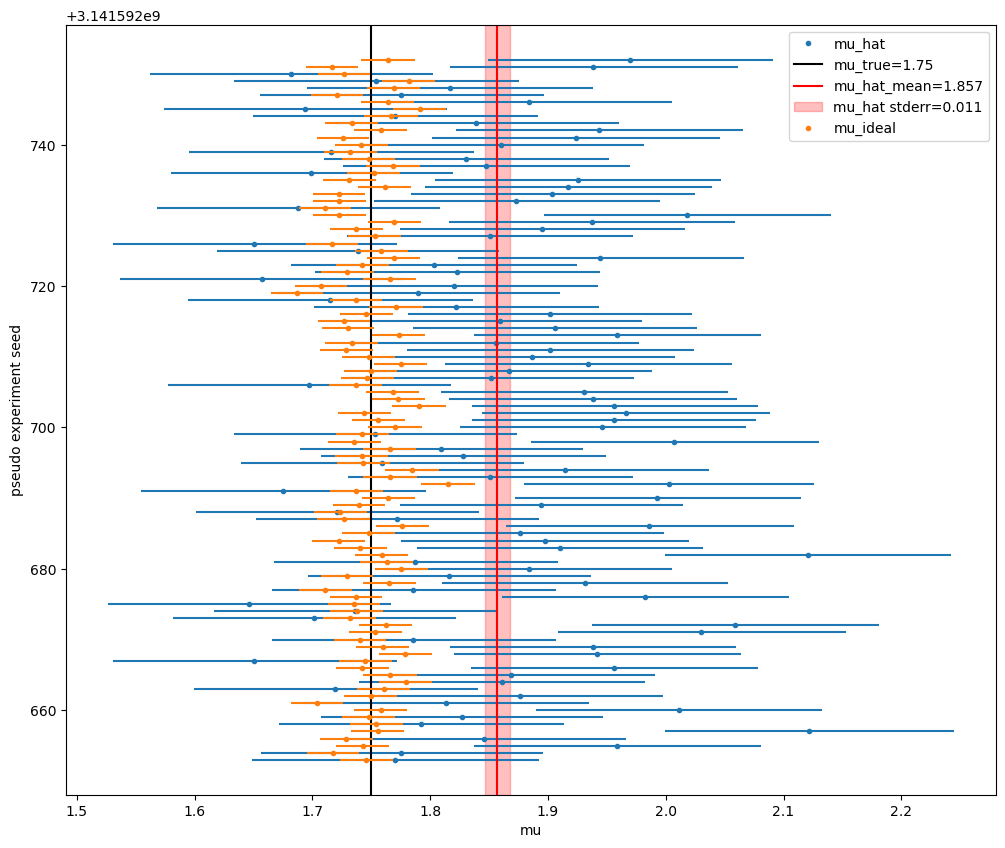

In [69]:
plt.figure(figsize=(12, 10))
# plot mu_hat
plt.plot(
    [result[1][0] for result in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    label='mu_hat',
    # alpha=0.5,
)
# plot mu_hat error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [result[1][1][0] for result in pseudo_results],
    [result[1][1][1] for result in pseudo_results],
    # linestyles='solid',
    # label='p16-p84',
    # alpha=0.5,
)
# plot mu_true
plt.axvline(mu_true, color='black', label=f'{mu_true=}')
# plot mu_hat mean
plt.axvline(intervals.mean(1).mean(), color='r', label=f'mu_hat_mean={intervals.mean(1).mean():.3f}')
# plot mu_hat stderr
plt.axvspan(
    intervals.mean() - intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    intervals.mean() + intervals.mean(1).std() / np.sqrt(intervals.shape[0]),
    color='r',
    alpha=0.25,
    label=f'mu_hat stderr={intervals.mean(1).std() / np.sqrt(intervals.shape[0]):.3f}',
)
plt.xlabel('mu')
plt.ylabel(f'pseudo experiment seed')
# plt.twiny()
# plot mu_ideal = sig_observed / sig_expected
plt.plot(
    [counts['htautau'] / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [seed for seed, *_ in pseudo_results],
    '.',
    color='C1',
    label='mu_ideal',
    # alpha=0.5,
)
# plot mu_ideal error bars
plt.hlines(
    [seed for seed, *_ in pseudo_results],
    [(counts['htautau'] - np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    [(counts['htautau'] + np.sqrt(counts['htautau'])) / (pseudo_exp_frac * valid_set['weights'][valid_set['labels'] == 1].sum()) for *_, counts in pseudo_results],
    color='C1',
    # linestyles='dashed',
    # label='p16-p84 poisson',
    # alpha=0.5,
)
# plt.xlim(0, 3)
plt.legend()

Text(0.5, 0, 'pull')

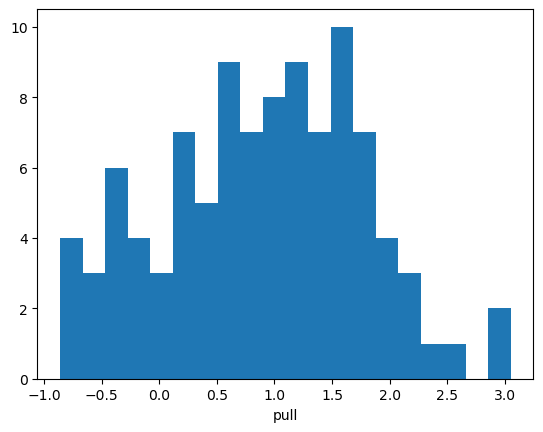

In [70]:
plt.hist(
    (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2), # pulls
    bins=20,
)
plt.xlabel('pull')

In [69]:
for name in valid_set['data'].columns:
    if valid_set['data'][name].dtype != np.float32:
        print('Train:', name, valid_set['data'][name].dtype)
    if pseudo_exp_data['data'][name].dtype != np.float32:
        print('Test: ', name, pseudo_exp_data['data'][name].dtype)

Train: DER_deltar_had_lep float64
Test:  DER_deltar_had_lep float64
Train: DER_met_phi_centrality float64
Test:  DER_met_phi_centrality float64


In [144]:
def pull_hist(intervals, mu_true=1, bins=100):
    pulls = (intervals.mean(1) - mu_true) / ((intervals[:, 1] - intervals[:, 0]) / 2)
    return np.histogram(pulls, bins=bins)

Text(0, 0.5, 'one sigma width')

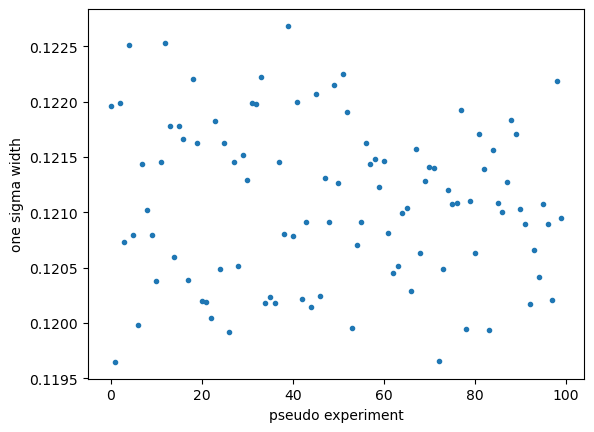

In [71]:
plt.plot((intervals[:, 1] - intervals[:, 0]) / 2, '.')
plt.xlabel('pseudo experiment')
plt.ylabel('one sigma width')
# plt.twinx()
# plt.plot(intervals.mean(1), '.', color='r')
# plt.ylabel('mu_hat')

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
def visualize_scatter(ingestion_result_dict, ground_truth_mus):
    plt.figure(figsize=(6, 4))
    for key in ingestion_result_dict.keys():
        ingestion_result = ingestion_result_dict[key]
        mu_hat = np.mean(ingestion_result["mu_hats"])
        mu = ground_truth_mus[key]
        plt.scatter(mu, mu_hat, c='b', marker='o')
    
    plt.xlabel('Ground Truth $\mu$')
    plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
    plt.title('Ground Truth vs. Predicted $\mu$ Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def visualize_coverage(ingestion_result_dict, ground_truth_mus):

    for key in ingestion_result_dict.keys():
        plt.figure( figsize=(5, 5))

        ingestion_result = ingestion_result_dict[key]
        mu = ground_truth_mus[key]
        mu_hats = np.mean(ingestion_result["mu_hats"])
        p16s = ingestion_result["p16"]
        p84s = ingestion_result["p84"]
        
        # plot horizontal lines from p16 to p84
        for i, (p16, p84) in enumerate(zip(p16s, p84s)):
            plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

        plt.vlines(x=mu_hats, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed', label='Predicted $\mu$')
        plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='g', linestyles='dashed', label='Ground Truth $\mu$')
        plt.xlabel('mu')
        plt.ylabel('psuedo-experiments')
        plt.title(f'mu distribution - Set_{key}')
        plt.legend()
        
    plt.show()


In [ ]:
from score import Scoring

In [ ]:
# Initialize Score
score = Scoring()

In [ ]:
score.load_ingestion_results(output_dir)

In [ ]:
# Compute Score
score.compute_scores(test_settings)

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

In [ ]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")